In [1]:
import numpy as np

def calculate_cooling_load(T_chwr, T_chws, C_p=4200, rho=1000):
    return (C_p * rho * (T_chwr - T_chws)) / 3600

def calculate_reward(T_chwr, x_comfort, x_energy,  P_chiller, P_chiller_nominal=100000, beta1=0.25, beta2=4.15, beta3=-1, beta4=1):
    U_comfort = 1 / (1 + beta1 * np.exp(beta2 * (T_chwr - 17)))
    U_energy =  beta3 * ((np.sum(P_chiller))/P_chiller_nominal) + beta4
    return U_comfort * x_comfort + U_energy * x_energy


In [5]:
# Define Q-learning parameters
alpha = 0.7  # Learning rate
gamma = 0.01  # Discount factor
epsilon = 0.1  # Exploration rate

# Define the number of discrete states and actions
num_actions = 3  # Increase, remain same, decrease
num_states_per_dimension = 25  # Number of discrete states for each dimension

# Define the range for cooling load and outdoor temperature
cooling_load_range = (0, 100000)  # Range of cooling load values
outdoor_temp_range = (15, 40)     # Range of outdoor temperature values (excluded 40)

# Define the discretization step for cooling load and outdoor temperature
cooling_load_step = (cooling_load_range[1] - cooling_load_range[0]) / (num_states_per_dimension - 1)
outdoor_temp_step = (outdoor_temp_range[1] - outdoor_temp_range[0]) / (num_states_per_dimension - 1)

# Initialize the Q-table with zeros
Q = np.zeros((num_states_per_dimension, num_states_per_dimension, num_actions))



def discretize_state(cooling_load, outdoor_temp, num_states_per_dimension=25):

    # Define the range for cooling load and outdoor temperature
    cooling_load_range = (0, 100000)  # Range of cooling load values
    outdoor_temp_range = (15, 40)     # Range of outdoor temperature values

    # Calculate the step size for each dimension
    cooling_load_step = (cooling_load_range[1] - cooling_load_range[0]) / num_states_per_dimension
    outdoor_temp_step = (outdoor_temp_range[1] - outdoor_temp_range[0]) / num_states_per_dimension

    # Discretize cooling load and outdoor temperature values into bins
    cooling_load_bin = min(int(cooling_load / cooling_load_step), num_states_per_dimension - 1)
    outdoor_temp_bin = min(int((outdoor_temp - outdoor_temp_range[0]) / outdoor_temp_step), num_states_per_dimension - 1)

    return cooling_load_bin, outdoor_temp_bin

# Example usage:
cooling_load = 50000  # Example cooling load value
outdoor_temp = 35    # Example outdoor temperature value

# Discretize the values and get the corresponding column indices out of 25 for each dimension
cooling_load_column, outdoor_temp_column = discretize_state(cooling_load, outdoor_temp)
print("Column index for cooling load (out of 25):", cooling_load_column)
print("Column index for outdoor temperature (out of 25):", outdoor_temp_column)


# Define function to select action using epsilon-greedy policy
def select_action(cooling_load_state, outdoor_temp_state,beta5=-0.25,beta6=20):
    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)   # Exploration
        action_mapping = {
        0: -1,  # Decrease setpoint temperature by 1 degree
        1: 0,   # Maintain current setpoint temperature
        2: 1    # Increase setpoint temperature by 1 degree
        }

        # Update Setpoint Temperature based on Chosen Action
        delta_setpoint = action_mapping[action]
        new_setpoint = beta5*T_outdoor.value + beta6 + delta_setpoint
        T_chws_set.value = new_setpoint
        return action  # Exploration
    else:
        action = np.argmax(Q[cooling_load_state, outdoor_temp_state])   # Exploitation
        action_mapping = {
        0: -1,  # Decrease setpoint temperature by 1 degree
        1: 0,   # Maintain current setpoint temperature
        2: 1    # Increase setpoint temperature by 1 degree
        }

        # Update Setpoint Temperature based on Chosen Action
        delta_setpoint = action_mapping[action]
        new_setpoint = T_chws_set.value + delta_setpoint
        T_chws_set.value = new_setpoint
        return action

# Define function to update Q-table
def update_Q_table(cooling_load_state,outdoor_temp_state, action, reward, next_cooling_load_state, next_outdoor_temp_state):
    best_next_action = np.argmax(Q[next_cooling_load_state, next_outdoor_temp_state])
    Q[cooling_load_state,outdoor_temp_state, action] += alpha * (reward + gamma * Q[next_cooling_load_state, next_outdoor_temp_state, best_next_action] - Q[cooling_load_state,outdoor_temp_state, action])




Column index for cooling load (out of 25): 12
Column index for outdoor temperature (out of 25): 20


In [9]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']
emeter = [env.variable(dict(variable_name='Chiller Electricity Rate', variable_key=key)) for key in keys]

T_outdoor = env.variable(dict(
    variable_name='Site Outdoor Air Drybulb Temperature',
    variable_key='ENVIRONMENT'
))

F_chw = env.variable(dict(variable_name='System Node Mass Flow Rate', variable_key='CHW Loop Supply Side'))
T_chws = env.variable(dict(variable_name='Chiller Evaporator Outlet Temperature', variable_key='Chiller'))
T_chwr = env.variable(dict(variable_name='Chiller Evaporator Inlet Temperature', variable_key='Chiller'))

T_chws_set = env.actuator(dict(component_type='System Node Setpoint',control_type = 'Temperature Setpoint', actuator_key='CHW Loop Supply Side Outlet'))


sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./new1ch.idf',
    verbose=True,
)
print('output', 'build3/demo-eplus',  file=__import__('sys').stderr)

output build3/demo-eplus


In [10]:
# Define variables to store training metrics
totalChillerPower = []
while True:
    sm_stepf()
    try: 
        if (emeter[0].value or emeter[0].value or emeter[0].value):
            # Get current state
            cooling_load = calculate_cooling_load(T_chwr.value, T_chws.value)
            outdoor_temp = T_outdoor.value
            cooling_load_state, outdoor_temp_state = discretize_state(cooling_load, outdoor_temp)
        
            # Select action
            action = select_action(cooling_load_state, outdoor_temp_state)
        
            # Take action and observe next state and reward
            # Perform action in the environment and get next state, reward, and done flag
            
            totalPower = emeter[0].value + emeter[1].value + emeter[2].value
            totalChillerPower.append(totalPower)
            reward = calculate_reward(T_chwr.value, 0.4, 0.6 , totalPower )
        
            print(rf"emeter={emeter[0].value,emeter[1].value,emeter[2].value}) (Reward={reward}) (T_outdoor={T_outdoor.value}) (T_chws={T_chws.value}) (T_chwr={T_chwr.value}) (T_chws_set={T_chws_set.value} ", flush=True, file=__import__('sys').stderr)


            # Get next state
            sm_stepf()
            next_cooling_load = calculate_cooling_load(T_chwr.value, T_chws.value)
            next_cooling_load_state, next_outdoor_temp_state = discretize_state(next_cooling_load, T_outdoor.value)

            # Update Q-table
            update_Q_table(cooling_load_state, outdoor_temp_state, action, reward, next_cooling_load_state, next_outdoor_temp_state)
        
            # Update variables for next iteration
            cooling_load_state, outdoor_temp_state = next_cooling_load_state, next_outdoor_temp_state
            
        else:
            sm_stepf()
       
    except ooep.ems.NotReadyError: pass

emeter=(395.0528561953612, 0.0, 0.0)) (Reward=0.9976296828628278) (T_outdoor=24.233333333333334) (T_chws=6.0) (T_chwr=6.70429679818834) (T_chws_set=5.0 
emeter=(700.5376095797653, 0.0, 0.0)) (Reward=0.9957967743425215) (T_outdoor=24.25) (T_chws=6.000000000000001) (T_chwr=7.343422303775457) (T_chws_set=5.0 
emeter=(1046.0857219672241, 0.0, 0.0)) (Reward=0.9937234856681967) (T_outdoor=24.266666666666666) (T_chws=6.0) (T_chwr=8.030256509524342) (T_chws_set=5.0 
emeter=(1288.584414058071, 0.0, 0.0)) (Reward=0.9922684935156515) (T_outdoor=24.28333333333333) (T_chws=6.0) (T_chwr=8.648337784336265) (T_chws_set=5.0 
emeter=(1550.0577701137092, 0.0, 0.0)) (Reward=0.9906996533793168) (T_outdoor=24.3) (T_chws=6.0) (T_chwr=9.233849331150411) (T_chws_set=5.0 
emeter=(1750.9577164954421, 0.0, 0.0)) (Reward=0.9894942537010187) (T_outdoor=24.5) (T_chws=6.0) (T_chwr=9.750983464126671) (T_chws_set=12.875 
emeter=(28455.261199884226, 0.0, 0.0)) (Reward=0.8292684285456209) (T_outdoor=24.700000000000003) (

Exception in thread Thread-6 (run_blocking):
Traceback (most recent call last):
  File "e:\Softwares\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\Asus Pro\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "e:\Softwares\Python312\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "e:\Softwares\Python312\Lib\site-packages\energyplus\ooep\addons\state\__init__.py", line 107, in run_blocking
    return self._env(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Softwares\Python312\Lib\site-packages\energyplus\ooep\ems.py", line 530, in __call__
    return super().__call__(*args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Softwares\Python312\Lib\site-packages\energyplus\ooep\ems.py", line 76, in __call__
    return self._exec(*args)
           ^^^^^^^^^^^^^^^^^
  File "e:\Softwares\Python312\Lib\site-pac

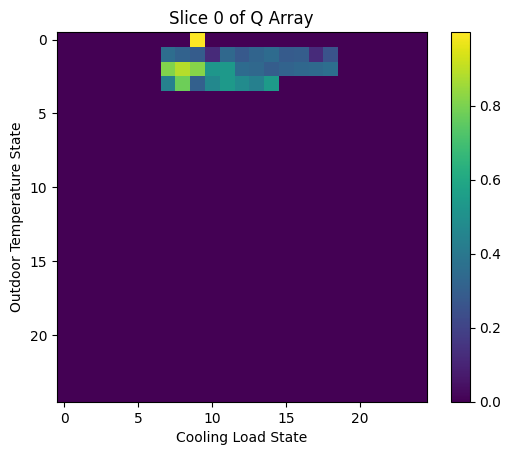

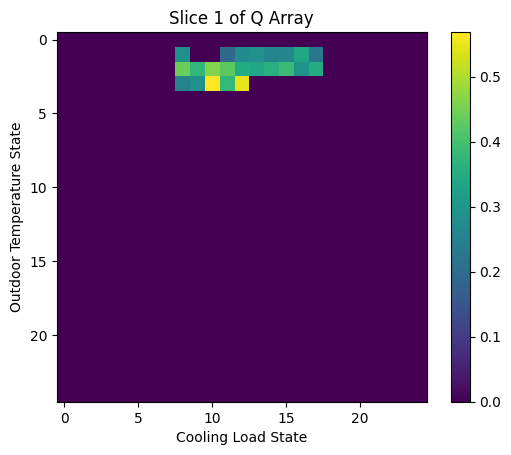

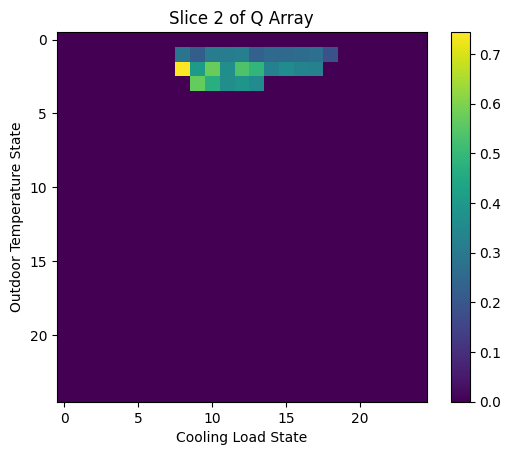

In [6]:
import matplotlib.pyplot as plt

# Iterate over each slice along the third dimension
for slice_index in range(Q.shape[2]):
    # Select the slice to visualize
    Q_slice = Q[:,:,slice_index]
    
    # Plot the slice using imshow
    plt.imshow(Q_slice, cmap='viridis')  # Choose a colormap (e.g., 'viridis')
    plt.colorbar()  # Add color bar for reference
    plt.title(f'Slice {slice_index} of Q Array')
    plt.xlabel('Cooling Load State')
    plt.ylabel('Outdoor Temperature State')
    plt.show()



Mean Power: 109446.71255809595
Median Power: 114707.4920994933
Standard Deviation of Power: 20428.40014424652
Minimum Power: 15982.14982734085
Maximum Power: 182276.71229571576


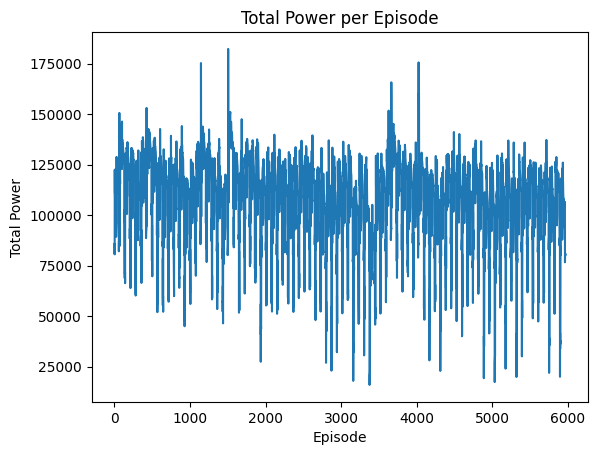

In [8]:

import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(totalChillerPower)
median_power = np.median(totalChillerPower)
std_power = np.std(totalChillerPower)
min_power = np.min(totalChillerPower)
max_power = np.max(totalChillerPower)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(totalChillerPower)
plt.xlabel('Episode')
plt.ylabel('Total Power')
plt.title('Total Power per Episode')
plt.show()


Mean Power: 98566.11275187388
Median Power: 104643.16880943318
Standard Deviation of Power: 23294.0027124624
Minimum Power: 700.5376095797653
Maximum Power: 159992.2613496869


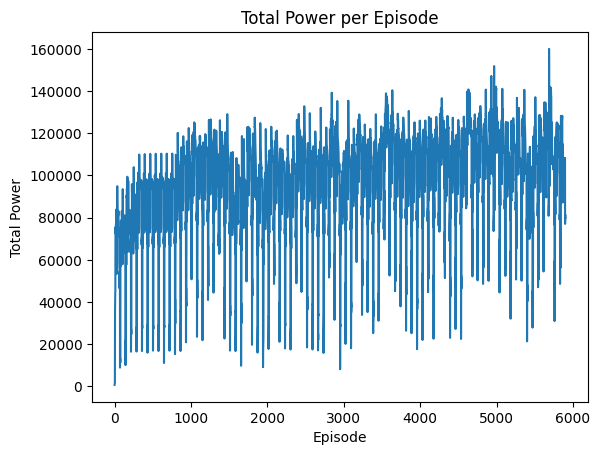

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(totalChillerPower)
median_power = np.median(totalChillerPower)
std_power = np.std(totalChillerPower)
min_power = np.min(totalChillerPower)
max_power = np.max(totalChillerPower)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(totalChillerPower)
plt.xlabel('Episode')
plt.ylabel('Total Power')
plt.title('Total Power per Episode')
plt.show()

Mean Power: 102984.70249642516
Median Power: 108413.72137058532
Standard Deviation of Power: 22793.932035243073
Minimum Power: 395.0528561953612
Maximum Power: 202575.34921730767


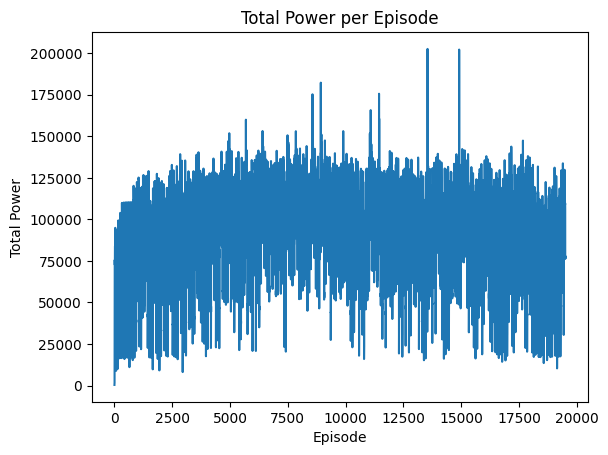

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(totalChillerPower)
median_power = np.median(totalChillerPower)
std_power = np.std(totalChillerPower)
min_power = np.min(totalChillerPower)
max_power = np.max(totalChillerPower)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(totalChillerPower)
plt.xlabel('Episode')
plt.ylabel('Total Power')
plt.title('Total Power per Episode')
plt.show()